/tmp/ipython-input-1685228008.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-1685228008.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u


=== Logistic Regression ===
Accuracy: 0.918918918918919
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.93      0.88      0.90        32

    accuracy                           0.92        74
   macro avg       0.92      0.91      0.92        74
weighted avg       0.92      0.92      0.92        74


=== Decision Tree ===
Accuracy: 0.9054054054054054
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92        42
           1       0.93      0.84      0.89        32

    accuracy                           0.91        74
   macro avg       0.91      0.90      0.90        74
weighted avg       0.91      0.91      0.90        74


=== Random Forest ===
Accuracy: 0.9864864864864865
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
    

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:25:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.8918918918918919
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.88      0.88      0.88        32

    accuracy                           0.89        74
   macro avg       0.89      0.89      0.89        74
weighted avg       0.89      0.89      0.89        74



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:25:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-1685228008.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")



=== XGBoost after GridSearchCV ===
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Accuracy: 0.9459459459459459
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        42
           1       1.00      0.88      0.93        32

    accuracy                           0.95        74
   macro avg       0.96      0.94      0.94        74
weighted avg       0.95      0.95      0.95        74



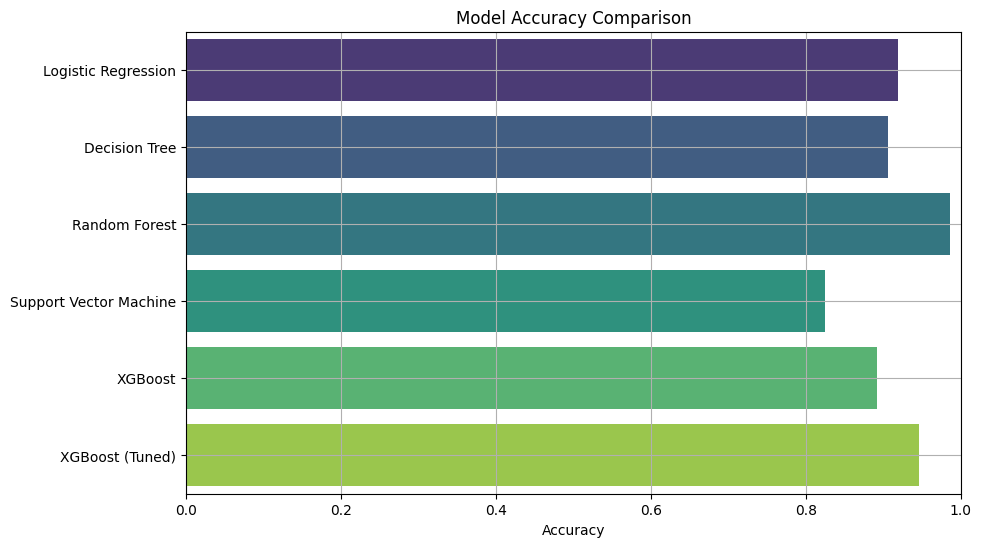

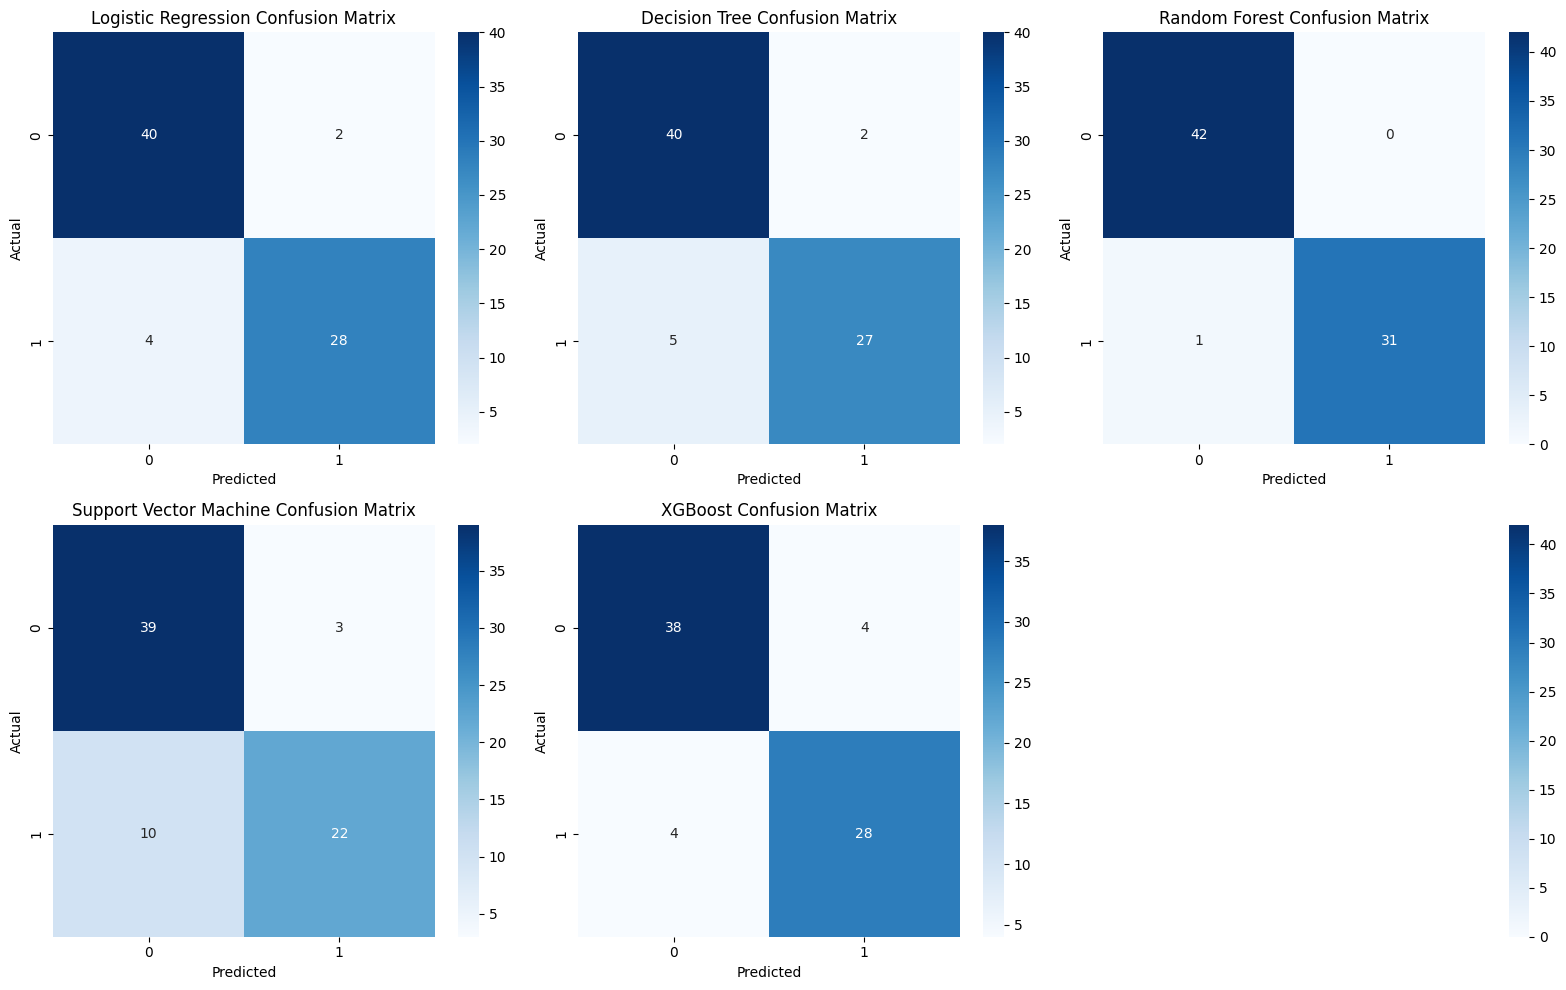

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("/content/loan-test.csv")
df.drop("Loan_ID", axis=1, inplace=True)

# Handle missing values
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Encode categorical columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# --- Simulate target variable with some logic ---
# Example: if applicant income + coapplicant income > median threshold & credit history is good, loan likely approved
income_threshold = (df['ApplicantIncome'] + df['CoapplicantIncome']).median()
df['Loan_Status'] = np.where(
    (df['ApplicantIncome'] + df['CoapplicantIncome'] > income_threshold) & (df['Credit_History'] == 1),
    1,  # Approved
    0   # Not approved
)

# Define features and target
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store results
results = {}
conf_matrices = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = acc
    conf_matrices[name] = cm

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Hyperparameter tuning for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("\n=== XGBoost after GridSearchCV ===")
print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

# Update results
results['XGBoost (Tuned)'] = accuracy_score(y_test, y_pred_best)
conf_matrices['XGBoost (Tuned)'] = confusion_matrix(y_test, y_pred_best)

# -------------------------------------------
# 🔢 Plot Accuracy Comparison
# -------------------------------------------
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = list(results.values())
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

# -------------------------------------------
# 📉 Plot Confusion Matrices
# -------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Hide unused subplot (6th)
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()
